Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [387]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


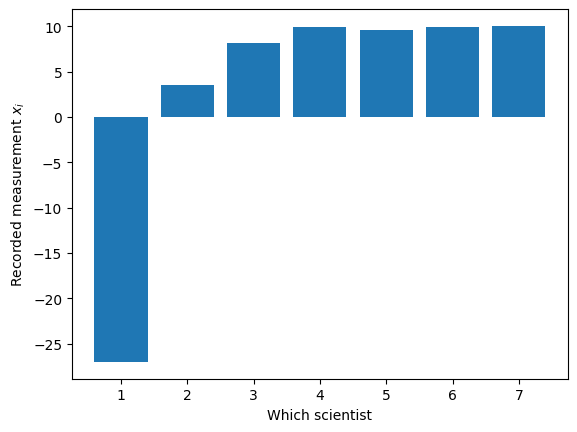

In [388]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


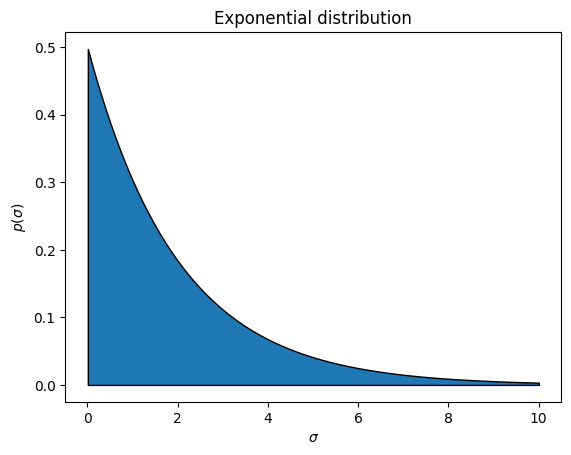

In [389]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\\sigma$")
plt.ylabel("$p(\\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [390]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """

    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    # p(mu, sigma, x | alpha, beta) = p(x | alpha, beta, mu, sigma) * p(mu | alpha, beta) * p(sigma | alpha, beta)
    if (sigma<=0).any():
        return -float('inf') #np.inf
    else:
        log_likelihood = dist.Normal(mu, sigma).log_prob(measurements).sum()
        log_prior_mu = dist.Normal(0, alpha).log_prob(mu)
        log_prior_sigma = dist.Exponential(beta).log_prob(sigma).sum()
        log_joint = log_likelihood + log_prior_mu + log_prior_sigma
        return log_joint

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [391]:
# (GRADING)

In [392]:
# (GRADING)

In [393]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [394]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    q_mu = dist.Normal(mu, 0.1)
    q_sigma = dist.Normal(sigma, 0.1*torch.ones(7,)) # -ve values dealt with in log_joint function
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [395]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [396]:
def mh_ratio(mu, sigma, alpha, beta):
    """
    Compute the Metropolis-Hastings acceptance ratio, given your proposal distribution and the target.

    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    accept_prob : scalar, number between 0 and 1
    new_mu      : proposed value for mu
    new_sigma   : proposed value for sigma
    """

    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    # YOUR CODE HERE
    # sampling candidates from our proposals
    candidate_mu = q_mu.sample()
    candidate_sigma = q_sigma.sample()

    # compute proposal probabilities
    reverse_mu, reverse_sigma = get_mcmc_proposal(candidate_mu, candidate_sigma)
    log_q_forward = q_mu.log_prob(candidate_mu) + q_sigma.log_prob(candidate_sigma).sum()
    log_q_reverse = reverse_mu.log_prob(mu) + reverse_sigma.log_prob(sigma).sum()

    # compute posterior probabilities
    p_proposal = log_joint(candidate_mu, candidate_sigma, alpha, beta)
    p_current = log_joint(mu, sigma, alpha, beta)

    # compute log_alpha with proposal correction
    # log_alpha = (p_proposal + log_q_reverse) - (p_current + log_q_forward)
    
    # compute log_alpha with symmetric proposal simplification
    log_alpha = p_proposal - p_current

    log_accept_prob = np.min([0, log_alpha])
    accept_prob = np.exp(log_accept_prob)

    return accept_prob, candidate_mu, candidate_sigma


## Running MCMC

We've supplied the outer loop for you, and an `mcmc_step` function -- it will call and execute your `mh_ratio` function. You should *not* need to edit these functions below!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [397]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    Run a sigle MCMC step. Calls your `mh_ratio` function.
    
    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    accept_prob, new_mu, new_sigma = mh_ratio(mu, sigma, alpha, beta)
    if dist.Bernoulli(accept_prob).sample():
        mu = new_mu
        sigma = new_sigma
        accepted = True
    return mu, sigma, accepted

def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [398]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE
    N_samples = 10000
    N_burnin = 1000
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [399]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.5039


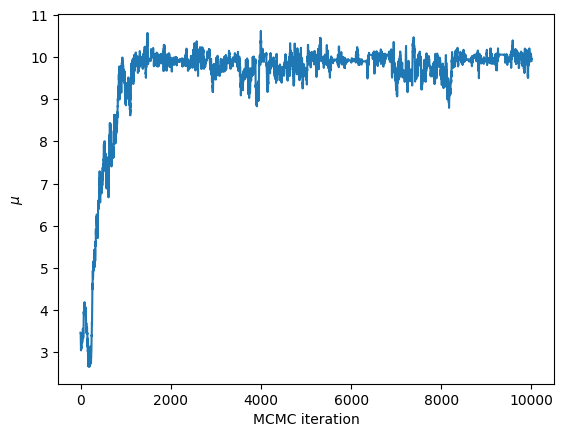

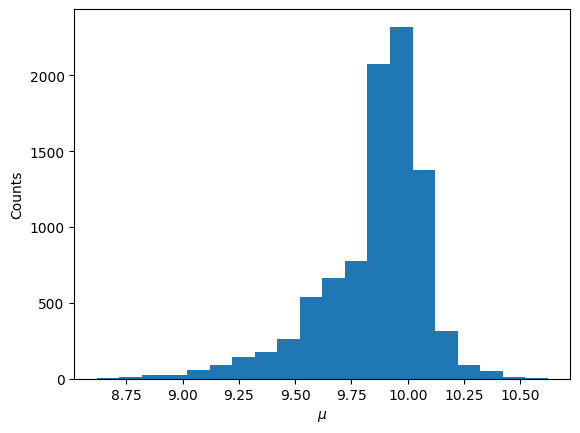

In [400]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\\mu$")
plt.ylabel("Counts");

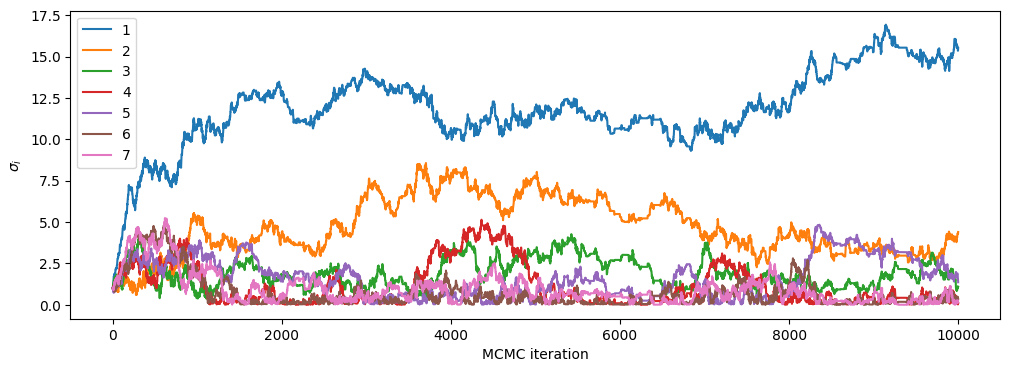

In [401]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\\sigma_i$");

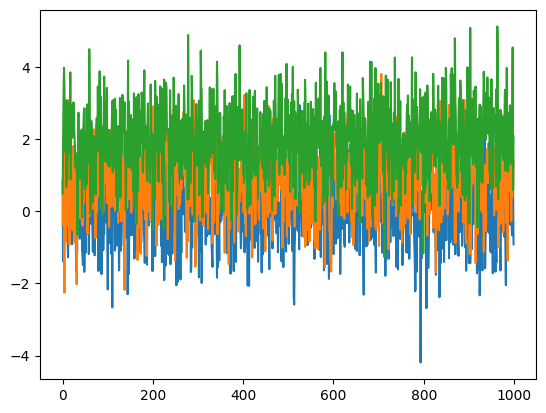

In [402]:
plt.plot(np.random.randn(1000,3) +np.arange(3))

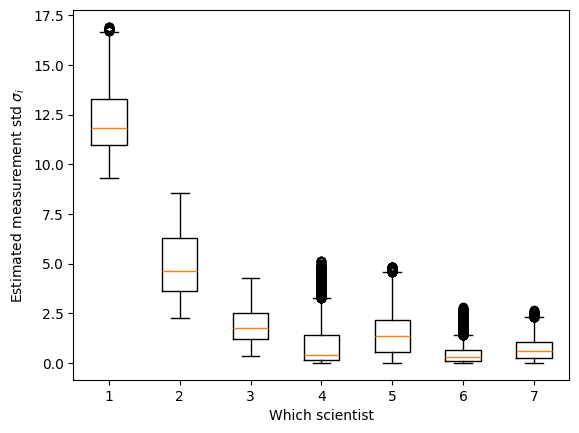

In [403]:
plt.boxplot(sigma_chain[N_burnin:].numpy(), positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [404]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # YOUR CODE HERE
    mu_samples = mu_chain[N_burnin:]
    mu = mu_samples.mean()
    return mu
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # YOUR CODE HERE
    mu_samples = mu_chain[N_burnin:]
    mu_lt_9_samples = mu_samples < 9
    estimate = mu_lt_9_samples.float().mean()
    return estimate

In [405]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.8546
Pr(mu < 9) = 0.0061


#### Ignore the following cells. They are used by the grading system.

In [406]:
# (GRADING)

In [407]:
# (GRADING)

In [408]:
# (GRADING)

In [409]:
# (GRADING)

In [410]:
# (GRADING)

# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, **in MAX 150 WORDS EACH**, for up to two points each.

1. Describe your choices of MCMC proposal distributions. Why did you choose them? How do you evaluate whether they are "good"?
2. Here, the parameters $\alpha$ and $\beta$ were left fixed. Suppose instead we would like to do MCMC inference over them as well. Outline everything that would be necessary to implement this — what new functions would you have to define, and what would need to change relative to your existing code? How do you think this might change your results, if at all?


YOUR ANSWER HERE

1) 

I chose Normal proposal distributions, centered at the current values and with standard deviation 0.1.  The Normal distribution is symmetric, and so simplifies the MH ratio to only require target density ratios.  It is also suitable because the parameters are continuous.  0.1 was selected as the standard deviation by light empirical testing (tested from 0.05-1), with performance evaluated as below.

The performance is assessed by looking at the acceptance ratio and the MCMC chains.  The acceptance ratio is found to be ~0.5, which is not so low that we get slow inefficient mixing, but not so high that our steps are too small which would result in low exploration.  The MCMC chains show good mixing, not getting stuck at a particular value, and they roughly converge after a burn-in period.

2) 

To perform inference over alpha and beta as well, we would need to extend log_joint() with hyperprior definitions and their propagation through the log joint calculation, extend get_mcmc_proposal to return proposals for alpha and beta as well, extend mh_ratio to sample and evaluate acceptance for all four parameters, and finally extend run_mcmc to track MCMC chains for alpha and beta also.  No further new functions are required.

Doing this would effectively allow the hyperparameters to be informed by the collected data, and an uncertainty in them to be captured.  This allows more flexibility especially if our previous hyperpriors were poor, but could risk overfitting and lead to poor generalisation due to the limited data (we only have 7 observations!).  With sufficient data, whether we perform inference on alpha and beta or not should not significantly affect the results.